#Hypothesis Testing, Part 2: Comparisons

So far, we have learned [how to fit a function to data](fits2.ipynb), and how to [assess the quality of the fit](chisquare.ipynb).  However, the questions we want to ask often involve comparisons rather than absolute agreement:

* is this dataset consistent with background, or does it indicate the presence of signal?
* is this distribution better described by model A or model B?
* are these two sets of data consistent with each other?

Although it is intuitively obvious that we should prefer lower &chi;<sup>2</sup>, or larger log &#8466;, we really need *quantitative* measures of the relative merits of different models, so that different groups will use consistent standards. 

##The null hypothesis

A key concept in hypothesis testing is the idea of the **null hypothesis**.  This is essentially a formal statement of what you expect if nothing interesting is happening.  The purpose of a statistical hypothesis test is to reject or fail to reject the null hypothesis.  

It is important to define the null hypothesis and its expectation **before** you conduct the test.  If you look at the data first and define your test based on what you see, the probabilities that you derive will be biased.  In particle physics, the null hypothesis is that there is no signal (e.g. no Higgs boson) and its expectation is that the sample will consist entirely of background.  The distribution of data expected from the null hypothesis is determined using simulations, and/or "control regions" or "sidebands" consisting of data selected so as to be similar in most respects to the signal but *not* to contain signal events.  For example, if you are looking for a new particle that is predicted to decay into &mu;<sup>+</sup>&mu;<sup>&minus;</sup> and you expect your background to consist of events that happen to contain two muons produced independently, a suitable control sample would be "like-sign" muon pairs, &mu;<sup>+</sup>&mu;<sup>+</sup> and &mu;<sup>&minus;</sup>&mu;<sup>&minus;</sup>.  Such a sample would include all the effects produced by applying cuts to select muons, and would be expected to contain the same number of events if there is an equal probability of producing a &mu;<sup>+</sup> and a &mu;<sup>&minus;</sup>, but would not contain any signal events (assuming that your detector can be trusted to get the sign of the charge right).

Note that failure to reject the null hypothesis is not proof that the null hypothesis is true: the signal may be there, but at too low a level to produce a statistically significant result.

##Case study: the DM-ICE experiment

[DM-ICE](http://physicsbuzz.physicscentral.com/2014/02/looking-for-darkness-in-ice.html) is a dark matter search experiment based at the South Pole.  The experiment is looking for an [annual modulation](http://www.hep.shef.ac.uk/research/dm/intro.php) in its signal caused by the motion of the Earth around the Sun, which should cause a &sim;7% fluctuation in the dark matter signal (therefore a &lt;7% effect in the observed data, which one would expect to include some unmodulated background as well as signal).  Because we know the orientation of the Earth's orbit with respect to the Sun's motion around the Galactic centre, the period and phase of the expected modulation signal are known: only the amplitude is free.

* **Null hypothesis**: there is no annual modulation in the data.
* **Alternative hypothesis**: there is a sinusoidal variation of the form sin(&omega;*t* + &phi;), where &omega; = 2&pi;  and 2&pi;&phi; = 0.42, if _t_ is in years.

The code below reads in a data file which contains two years' worth of data.  Each line of the file contains one month's data, in the format 

    year month counts(2-4 keV) counts(4-6 keV) livetime(hours)
    
(the livetime is the number of hours in the month for which the detector was taking data).  Cuts have been applied to the data to remove noise &ndash; that is, signals in the photomultipliers that are not consistent with nuclear recoils in the scintillator &ndash; although less-obvious background may still remain.  In the code, fits are made to both the null hypothesis and the alternative hypothesis, and the &chi;<sup>2</sup> values are compared.  Note that the null hypothesis is not a constant, but a line with gradient to be determined: this is to allow for any change in background rate caused by drifting of calibration constants or the like.

2-4 keV data: linear fit
Fitted parameters: 7.163 ± 0.052 ; -0.052 ± 0.035
Reduced χ²: 1.471 ; probability 0.071
2-4 keV data: linear fit with modulation
Fitted parameters: 7.167 ± 0.053 ; -0.055 ± 0.035 ; -0.020 ± 0.029
Reduced χ²: 1.517 ; probability 0.060
4-6 keV data: linear fit
Fitted parameters: 5.652 ± 0.046 ; -0.156 ± 0.031
Reduced χ²: 1.259 ; probability 0.186
4-6 keV data: linear fit with modulation
Fitted parameters: 5.660 ± 0.046 ; -0.161 ± 0.031 ; -0.035 ± 0.025
Reduced χ²: 1.225 ; probability 0.217


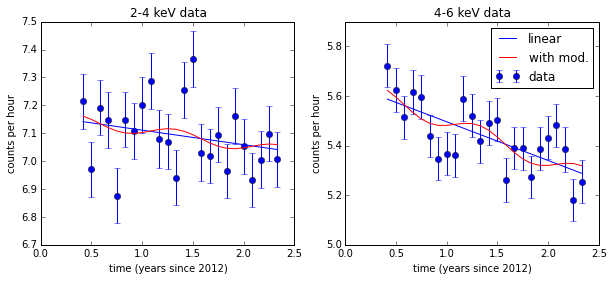

In [33]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as scopt
import scipy.stats as scst

def lin(x,a,b):
    return a + b*x

def linmod(x,a,b,c):
    return a + b*x +c*np.sin(2*np.pi*(x+0.42)) #zero phase for modulation is beginning of June

f=open('dmice-selevtcnt.txt','r') #open a data file

year = np.zeros(24)
month = np.zeros(24)
ct24 = np.zeros(24)
ct46 = np.zeros(24)
livetime = np.zeros(24)
i = 0

for line in f:
    items = line.split() #separate the contents of the line by spaces, and read each "word" into a separate item in list
    if len(items)==0:
        break
    year[i] = float(items[0]) #python reads file data as strings, but we want numbers, so convert
    month[i] = float(items[1])
    ct24[i] = float(items[2])
    ct46[i] = float(items[3])
    livetime[i] = float(items[4])
    i=i+1
    
f.close() #close the data file when we're finished with it

time = year - 2012. + month/12.
cph24 = ct24/livetime
cph46 = ct46/livetime
err24 = np.sqrt(ct24)/livetime  #Poisson statistical errors
err46 = np.sqrt(ct46)/livetime

fout = open('dmice-data.txt','w') #write out the reduced data
for lno in range(i):
    fout.write('%f %f %f %f %f \n'%(time[lno],cph24[lno],err24[lno],cph46[lno],err46[lno]))

fout.close()

lopt24,lcov24 = scopt.curve_fit(lin,time,cph24,sigma=err24,absolute_sigma=True) 
lmopt24,lmcov24 = scopt.curve_fit(linmod,time,cph24,sigma=err24,absolute_sigma=True)
al24 = lopt24[0]
bl24 = lopt24[1]
sigl24 = np.sqrt(np.diag(lcov24))
yvar = (cph24-lin(time,al24,bl24))*(cph24-lin(time,al24,bl24))/(err24*err24)
chi2l24 = yvar.sum()/(i-2)
chi2prob = scst.chi2.sf(yvar.sum(),i-2)
print('2-4 keV data: linear fit')
print('Fitted parameters: %5.3f'%al24,'\u00b1 %5.3f'%sigl24[0],'; %5.3f'%bl24,'\u00b1 %5.3f'%sigl24[1])
print('Reduced \u03c7\u00b2: %5.3f'%chi2l24,'; probability %5.3f'%chi2prob)

alm24 = lmopt24[0]
blm24 = lmopt24[1]
clm24 = lmopt24[2]
siglm24 = np.sqrt(np.diag(lmcov24))
yvar = (cph24-linmod(time,alm24,blm24,clm24))*(cph24-linmod(time,alm24,blm24,clm24))/(err24*err24)
chi2lm24 = yvar.sum()/(i-3)
chi2prob = scst.chi2.sf(yvar.sum(),i-3)
print('2-4 keV data: linear fit with modulation')
print('Fitted parameters: %5.3f'%alm24,'\u00b1 %5.3f'%siglm24[0],'; %5.3f'%blm24,'\u00b1 %5.3f'%siglm24[1],'; %5.3f'%clm24,'\u00b1 %5.3f'%siglm24[2])
print('Reduced \u03c7\u00b2: %5.3f'%chi2lm24,'; probability %5.3f'%chi2prob)

lopt46,lcov46 = scopt.curve_fit(lin,time,cph46,sigma=err46,absolute_sigma=True) 
lmopt46,lmcov46 = scopt.curve_fit(linmod,time,cph46,sigma=err46,absolute_sigma=True)
al46 = lopt46[0]
bl46 = lopt46[1]
sigl46 = np.sqrt(np.diag(lcov46))
yvar = (cph46-lin(time,al46,bl46))*(cph46-lin(time,al46,bl46))/(err46*err46)
chi2l46 = yvar.sum()/(i-2)
chi2prob = scst.chi2.sf(yvar.sum(),i-2)
print('4-6 keV data: linear fit')
print('Fitted parameters: %5.3f'%al46,'\u00b1 %5.3f'%sigl46[0],'; %5.3f'%bl46,'\u00b1 %5.3f'%sigl46[1])
print('Reduced \u03c7\u00b2: %5.3f'%chi2l46,'; probability %5.3f'%chi2prob)

alm46 = lmopt46[0]
blm46 = lmopt46[1]
clm46 = lmopt46[2]
siglm46 = np.sqrt(np.diag(lmcov46))
yvar = (cph46-linmod(time,alm46,blm46,clm46))*(cph46-linmod(time,alm46,blm46,clm46))/(err46*err46)
chi2lm46 = yvar.sum()/(i-3)
chi2prob = scst.chi2.sf(yvar.sum(),i-3)
print('4-6 keV data: linear fit with modulation')
print('Fitted parameters: %5.3f'%alm46,'\u00b1 %5.3f'%siglm46[0],'; %5.3f'%blm46,'\u00b1 %5.3f'%siglm46[1],'; %5.3f'%clm46,'\u00b1 %5.3f'%siglm46[2])
print('Reduced \u03c7\u00b2: %5.3f'%chi2lm46,'; probability %5.3f'%chi2prob)


plt.figure(1,figsize=(10,4))
plt.subplot(121)
plt.errorbar(time,cph24,yerr=err24,fmt='bo',label='data')
plt.plot(time,lin(time,al24,bl24),label='linear')
plt.plot(time,linmod(time,alm24,blm24,clm24),'r',label='with mod.')
plt.title('2-4 keV data')
plt.xlabel('time (years since 2012)')
plt.ylabel('counts per hour')
#plt.legend(loc='best')

plt.subplot(122)
plt.errorbar(time,cph46,yerr=err46,fmt='bo',label='data')
plt.plot(time,lin(time,al46,bl46),label='linear')
plt.plot(time,linmod(time,alm46,blm46,clm46),'r',label='with mod.')
plt.title('4-6 keV data')
plt.xlabel('time (years since 2012)')
plt.ylabel('counts per hour')
plt.legend(loc='best')

The first thing to note is that using a line of unknown gradient, rather than a constant, is clearly necessary for the 4-6 keV data (parameter _b_ is non-zero at 5&sigma;), but not for the 2-4 keV data (_b_ is non-zero at the level of about 1.5&sigma;, which is not significant).  The second thing is that it is pretty obvious that the null hypothesis is not rejected:

* the &chi;<sup>2</sup> for the null hypothesis is satisfactory &ndash; in no case is the probability of obtaining this high a &chi;<sup>2</sup> value from chance fluctuations less than 5%;
* the reduced &chi;<sup>2</sup> for the null hypothesis is not significantly greater than the &chi;<sup>2</sup> for the alternative hypothesis &ndash; in fact, for the 2-4 keV data it is actually lower (the decrease in total &chi;<sup>2</sup> is more than cancelled out by the reduction in degrees of freedom).

How can we quantify this?  Note that the two models are not independent: the modulation in the second model is simply added to the linear fit of the first hypothesis.  In this case, we can use the [**F-test**](https://en.wikipedia.org/wiki/F-test): construct
$$
F = \frac{(\chi^2_1 - \chi^2_2)/(p_2-p_1)}{\chi^2_2/(n-p_2)},
$$
where model 1 is the null hypothesis, with *p*<sub>1</sub> parameters, model 2 is the alternative hypothesis, with *p*<sub>2</sub> parameters, &chi;<sup>2</sup><sub>1,2</sub> are the corresponding values of (total, not reduced) &chi;<sup>2</sup> and *n* is the number of data points, and test this against the probability of the *F* distribution with degrees of freedom *p*<sub>2</sub> &minus; *p*<sub>1</sub> and *n* &minus; *p*<sub>1</sub> (the *F* distribution takes two values of NDOF as its arguments)

In [2]:
import numpy as np
import scipy.stats as scst

p1 = 2
p2 = 3
n = 24
chi224_1 = 32.362
chi224_2 = 31.857
chi246_1 = 27.698
chi246_2 = 25.725

f24 = ((chi224_1-chi224_2)/(p2-p1))/(chi224_2/(n-p2))
f46 = ((chi246_1-chi246_2)/(p2-p1))/(chi246_2/(n-p2))

sf24 = scst.f.sf(f24,n-p2,p2-p1)
sf46 = scst.f.sf(f46,n-p2,p2-p1)

print('Results of f-test:')
print('For 2-4 keV data f = %5.3f'%f24,' and survival fraction is %5.3f'%sf24)
print('For 4-6 keV data f = %5.3f'%f46,' and survival fraction is %5.3f'%sf46)

Results of f-test:
For 2-4 keV data f = 0.333  and survival fraction is 0.902
For 4-6 keV data f = 1.611  and survival fraction is 0.560


We would reject the null hypothesis if the survival fraction (i.e. the fraction of the distribution with *F* &gt; *F*<sub>obs</sub>) was less than some predefined value, say 0.01.  In this case, it is absolutely clear that there is no justification for preferring the alternative hypothesis over the null hypothesis.  We conclude that there is **no evidence** for annual modulation in these data.

Given the absence of evidence for modulation, we might wish to quote an upper limit on the amount of modulation that *could* be present in the data.  (Notice that in both cases the fitted amplitude came out unphysically negative!)  We can do this by scanning through the &chi;<sup>2</sup>.

##Other methods of comparison

If the two models we wish to compare are not "nested" &ndash; i.e. the alternative hypothesis is not the null hypothesis plus an addtional component &ndash; or if the uncertainties on the dependent variable are not Gaussian (the F-test, like &chi;<sup>2</sup>, assumes Gaussian errors), we might want to use a different method of comparing the two hypotheses.  A widely used method, especially if you are using a maximum likelihood estimator for your fits, is the **likelihood ratio** &#8466;<sub>2</sub>/&#8466;<sub>1</sub> (which is equivalent to the difference in &chi;<sup>2</sup> if the errors are Gaussian).

##Comparing two distributions

If you want to compare two datasets, rather than a dataset and a model, the standard method is the two-sample [**Kolmogorov-Smirnov**](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) (KS) test, which essentially looks at the difference between the two **cumulative distributions**.  This is a useful test because it is sensitive to differences in shape, not just mean and variance, and does not require an underlying model (though it is perfectly possible to use the KS test to compare experimental data with a theoretical model).  Python provides both a [two-semaple method](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ks_2samp.html) for comparing two datasets and a [one-sample method](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html) for comparing against a theoretical model.

KS parameter D = 0.1050 , probability = 0.4335


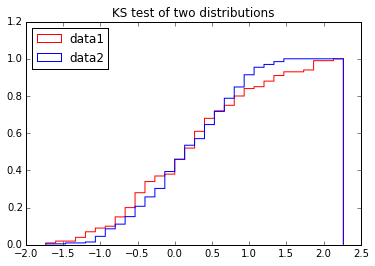

In [13]:
%matplotlib inline

import numpy as np
import scipy.stats as scst
import matplotlib.pyplot as plt

mean1 = 0.3
sigma1 = 1.0
data1 = np.random.normal(mean1,sigma1,100)

mean2 = 0.2
sigma2 = 0.7
data2 = np.random.normal(mean2,sigma2,200)

D,p = scst.ks_2samp(data1,data2)
print('KS parameter D = %.4f'%D,', probability = %.4g'%p)

counts,bins,patches = plt.hist(data1,30,histtype='step',cumulative=True,normed=True,color='r',label='data1')
counts,bins2,pacthes = plt.hist(data2,bins,histtype='step',cumulative=True,normed=True,color='b',label='data2')
plt.legend(loc='upper left')
plt.title('KS test of two distributions')

##Summary

Hypothesis testing is the key part of many scientific experiments.  In order to conduct a valid hypothesis test, you must proceed as follows:

1. Carefully state the **null hypothesis** and the **alternative hypothesis**.  If you are not clear exactly what you are testing, it will be very difficult to interpret the results of the test.

2. Consider the properties of your sample (for example, are the uncertainties normally distributed?), and of your hypotheses (are they independent, or is one nested inside the other?), and decide on an appropriate test statistic.

3. Decide what threshold you will apply to reject the null hypothesis.  (Particle physicists conventionally use 5&sigma; as the "discovery threshold", but this is a very stringent requirement: other fields routinely use *p* &lt; 5% or 1% as a threshold.)

4. Analyse your data according to the method you chose in (2), and intepret your results according to the threshold you chose in (3).

Note that it is very important to carry out step 3 **before** step 4, and not to change your mind when you look at the results.  Changing your procedure in the light of what the data look like is a sure way to bias your results!  (It *is* legitimate to look at your results, decide that your test statistic and/or your threshold was inappropriate, and then take more data and analyse the *new* sample according to modified criteria.  What you can't do is apply your modified criteria to the dataset that inspired you to modify them in the first place: that's circular reasoning.)

In conducting step 2, and particularly step 3, it is necessary to consider the effect of making a mistake.  There are two classes of errors:

* **Type I error** (**false positive**) &ndash; you reject the null hypothesis when it is in fact true;
* **Type II error** (**false negative**) &ndash; you fail to reject the null hypothesis when it is in fact false.

In most cases, one of these errors is more damaging than the other: for example, a Type II error on discovering the Higgs boson will correct itself when you collect more statistics, whereas a Type I error (announcing a discovery which subsequently turns out to be spurious) might ruin your reputation in the field; on the other hand, a Type II error in cancer screening (you fail to diagnose a cancer when it is there) is likely to be more damaging than a Type I error (you misdiagnose a benign condition as cancer).  This should be borne in mind when choosing your threshold: if the error to be avoided is a false positive, you set a very stringent rejection threshold, whereas if the dangerous error is a false negative, you relax your threshold.  

###Look-elsewhere effect

In calculating the probability of the null hypothesis, it is necessary to be careful about the statement of the alternative hypothesis.  For example, if your sample contains 100 events spread over 50 mass bins, and you have 10 events in one mass bin, this appears to reject the null hypothesis (the Poisson probability of observing 10 or more when only 2 are expected is 4.6&times;10<sup>-5</sup>).  However, if your alternative hypothesis (that there exists a new particle which should be seen in this decay mode) does not specify the mass of the particle, you would be equally impressed by getting 10 events in *any* bin, so you need to multiply this by 50, getting 2.3&times;10<sup>-3</sup>.  This is a significance of only just over 3&sigma;, and would not qualify as a discovery.  On the other hand, if your alternative hypothesis *predicts* the particle mass, and the claimed signal is in the right place, the probability of the null hypothesis is indeed 4.6&times;10<sup>-5</sup>.  While this still does not reach the 5&sigma; threshold demanded by particle physicists, it is over 4&sigma; and constitutes strong evidence for the alternative hypothesis.